# Scattering Parameters (S-Parameters) 


## How to find S-Parameters for an arbitrary device using a meep simulation

In this section we'll demonstrate how to find the s-params for any device using a meep simulation. We'll show both 2D and 3D simulations, but keep in mind that 2D s-params are not very accurate. We'll run through the steps using gdsfactory's default 2x2 mmi, and explain on the way how the principles can be applied to any component. 

### Step 1 - Import Geometry

For our simulation, it makes life easy if we add all of our sources and detectors into our gds before we import it into meep. For this tutorial I have already done this. For your simulations, you can modify your gds file directly in Klayout if you like a GUI, or you can use gdsfactory itself. If you like, you can also use meep to do the same thing, but I won't be showing how to do that here. 

Here is a picture of the gds we will be using. 

![Image of splitter file](https://raw.githubusercontent.com/BYUCamachoLab/Photonics-Bootcamp/main/book/images/Notebook_Images/mmi2x2_gds_with_ports.png)

I've added a box around the entire component (in purple) which will become the simulation region, and 8 lines, 2 on each end that will become the sources and detectors. I also added straight waveguides on the ports of the gdsfactory mmi so that my ports could be exactly where the light would enter and exit the component in an actual circuit. My sources are then slightly outside the mmi, in the waveguides.

So, now that we have a gds, lets import it into meep!

In [22]:
# Imports
import meep as mp 
import numpy
import matplotlib as plt 

Next we'll define a whole bunch of variables so our code is more readable down the line. 

In [30]:
res = 50 # the resolution of the simulation in pixels/um
three_d = False # Turn this to false for a 2D simulation

gds_file = "mmi2x2.gds" # The name of our gds file

# Here we define the layer numbers for each part of our gds
geometry_L = 1
cell_L = 2
port1_L = 4
port2_L = 3
port3_L = 5
port4_L = 6
source1_L = 8
source2_L = 7
source3_L = 9
source4_L = 10

# The Parameters for the frequencies we'll be using
lcen = 1.55 # Center wavelength
fcen = 1 / lcen # Center frequency
df = 0.2*fcen # Frequency Diameter

# The thickness of each material in our simulation (only used in 3D simulations)
t_oxide = 1.0
t_Si = 0.22
t_air = 0.78

dpml = 1 # Diameter of perfectly matched layers
cell_thickness = dpml + t_oxide + t_Si + t_air + dpml # Cell thickness

# The materials we will have in our simulation, silicon and SiO2
oxide = mp.Medium(epsilon=2.25)
silicon = mp.Medium(epsilon=12)

# Sets the min and max values for the cell and the silicon. Our simulation will be centered at y=0
cell_zmax = 0.5*cell_thickness if three_d else 0
cell_zmin = -0.5 * cell_thickness if three_d else 0
si_zmax = 0.5 * t_Si if three_d else 10 # In a 2D simulation, the geometry still has to have a thickness or it won't show up
si_zmin = -0.5 * t_Si if three_d else -10

Now, we'll import our geometries from the gds file

In [31]:
###################################################
# Now we actually import the geometry
geometry = mp.GDSII_prisms(silicon, gds_file, geometry_L, zmax=si_zmax, zmin=si_zmin) # Gets the geometry of the mmi
cell = mp.GDSII_vol(fname = gds_file, layer = cell_L, zmax=cell_zmax, zmin=cell_zmin) # cell geometry. We use mp.GDSII_vol() instead of mp.GDSII_prims() because they return different types
port1 = mp.GDSII_vol(fname = gds_file, layer = port1_L, zmax=cell_zmax, zmin=cell_zmin) # Port geometry
port2 = mp.GDSII_vol(fname = gds_file, layer = port2_L, zmax=cell_zmax, zmin=cell_zmin)
port3 = mp.GDSII_vol(fname = gds_file, layer = port3_L, zmax=cell_zmax, zmin=cell_zmin)
port4 = mp.GDSII_vol(fname = gds_file, layer = port4_L, zmax=cell_zmax, zmin=cell_zmin)
source1 = mp.GDSII_vol(fname = gds_file, layer = source1_L, zmax=cell_zmax, zmin=cell_zmin) # Source Geometry
source2 = mp.GDSII_vol(fname = gds_file, layer = source2_L, zmax=cell_zmax, zmin=cell_zmin)
source3 = mp.GDSII_vol(fname = gds_file, layer = source3_L, zmax=cell_zmax, zmin=cell_zmin)
source4 = mp.GDSII_vol(fname = gds_file, layer = source4_L, zmax=cell_zmax, zmin=cell_zmin)

if three_d: # Sets up the oxide cladding for a three d simulation (Not used in a 2D simulation)
    oxide_center = mp.Vector3(z=-0.5 * t_oxide)
    oxide_size = mp.Vector3(cell.size.x, cell.size.y, t_oxide)
    oxide_layer = [mp.Block(material=oxide, center=oxide_center, size=oxide_size)]
    geometry = geometry + oxide_layer

print(cell.size)
print(cell.center)

Vector3<35.5, 10.0, 0.0>
Vector3<2.75, 0.0, 0.0>


In [25]:
# Set up the sources for the simulation.
sources = [
    mp.EigenModeSource(
            src = mp.GaussianSource(fcen, fwidth=df),
            size=source1.size,
            center=source1.center,
            eig_band=1,
            eig_parity = mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z,
            eig_match_freq = True,

    ), 
    mp.EigenModeSource(
            src = mp.GaussianSource(fcen, fwidth=df),
            size=source2.size,
            center=source2.center,
            eig_band=1,
            eig_parity = mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z,
            eig_match_freq = True,

    ), 
    mp.EigenModeSource(
            src = mp.GaussianSource(fcen, fwidth=df),
            size=source3.size,
            center=source3.center,
            eig_band=1,
            eig_parity = mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z,
            eig_match_freq = True,

    ), 
    mp.EigenModeSource(
            src = mp.GaussianSource(fcen, fwidth=df),
            size=source4.size,
            center=source4.center,
            eig_band=1,
            eig_parity = mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z,
            eig_match_freq = True,

    )
]

     prism, center = (-5,-0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (0,-1.125,-10)
          (-10,-0.875,-10)
          (-10,-0.375,-10)
          (0,-0.125,-10)
          dielectric constant epsilon diagonal = (12,12,12)
     prism, center = (-5,0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (0,0.125,-10)
          (-10,0.375,-10)
          (-10,0.875,-10)
          (0,1.125,-10)
          dielectric constant epsilon diagonal = (12,12,12)
     prism, center = (10.5,0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (5.5,0.125,-10)
          (5.5,1.125,-10)
          (15.5,0.875,-10)
          (15.5,0.375,-10)
          dielectric constant epsilon diagonal = (12,12,12)
     prism, center = (10.5,-0.625,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (5.5,-1.125,-10)
          (5.5,-0.125,-10)
          (15.5,-0

<Axes: xlabel='X', ylabel='Y'>

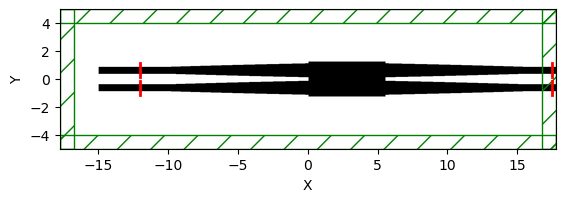

In [26]:
# Create Simulation
sim = mp.Simulation(
    resolution=res,
    cell_size=cell.size,
    boundary_layers=[mp.PML(dpml)],
    sources = sources,
    geometry = geometry
)

sim.plot2D()